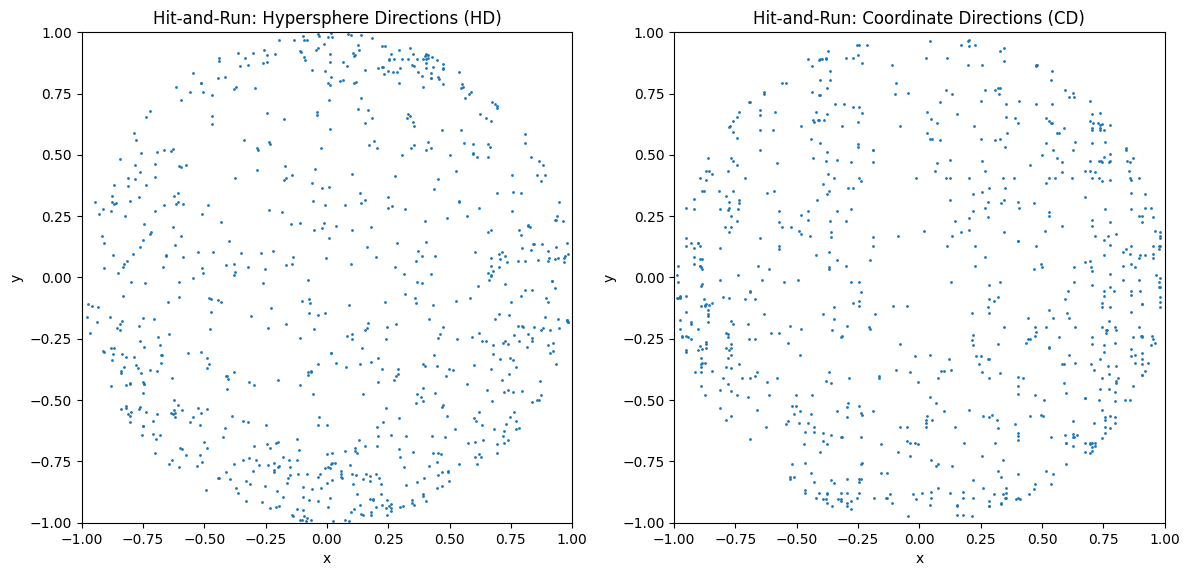

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def hit_and_run(initial_point, direction_distribution, step_distribution, n_steps, region_S):
    points = [initial_point]
    current_point = initial_point

    for _ in range(n_steps):
        direction = direction_distribution()
        max_step_size = find_max_step_size(current_point, direction, region_S)
        step_size = step_distribution(max_step_size)
        next_point = current_point + step_size * direction

        if region_S(next_point):
            current_point = next_point
            points.append(next_point)

    return points

def find_max_step_size(point, direction, region_S):
    step_size = 0.1
    while region_S(point + step_size * direction):
        step_size += 0.1
    return step_size

# ex 1 2d cirlce 
def region_S_circle(point):
    return np.linalg.norm(point) < 1 

def direction_distribution_hd():
    theta = np.random.uniform(0, 2 * np.pi)
    return np.array([np.cos(theta), np.sin(theta)])

def direction_distribution_cd():
    axis = np.random.choice([0, 1])
    direction = np.zeros(2)
    direction[axis] = np.random.choice([-1, 1])
    return direction

def step_distribution_uniform(max_step_size):
    return np.random.uniform(0, max_step_size)
initial_point = np.array([0.5, 0.5])
n_steps = 1000
points_hd = hit_and_run(initial_point, direction_distribution_hd, step_distribution_uniform, n_steps, region_S_circle)
points_cd = hit_and_run(initial_point, direction_distribution_cd, step_distribution_uniform, n_steps, region_S_circle)
plt.figure(figsize=(12, 6))

#hd
plt.subplot(1, 2, 1)
plt.scatter(*zip(*points_hd), s=1)
plt.title("Hit-and-Run: Hypersphere Directions (HD)")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')

# cd
plt.subplot(1, 2, 2)
plt.scatter(*zip(*points_cd), s=1)
plt.title("Hit-and-Run: Coordinate Directions (CD)")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


NameError: name 'points_hd_3D' is not defined

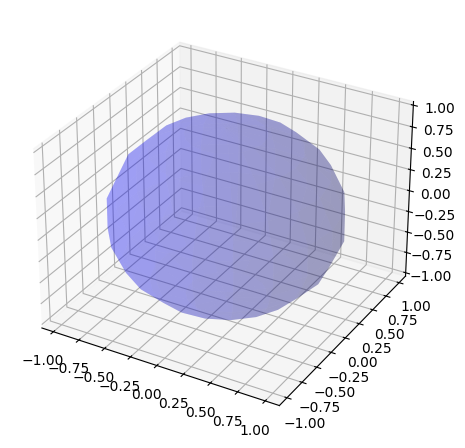

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_sphere(ax, radius=1, color='blue', alpha=0.2):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = radius * np.cos(u) * np.sin(v)
    y = radius * np.sin(u) * np.sin(v)
    z = radius * np.cos(v)
    ax.plot_surface(x, y, z, color=color, alpha=alpha)

def plot_convex_polyhedron(ax, vertices, color='green', alpha=0.2):
    hull = ConvexHull(vertices)
    for simplex in hull.simplices:
        triangle = [hull.points[simplex[0]], hull.points[simplex[1]], hull.points[simplex[2]], hull.points[simplex[0]]]
        tri = Poly3DCollection([triangle])
        tri.set_color(color)
        tri.set_alpha(alpha)
        ax.add_collection3d(tri)


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
plot_sphere(ax1)  # Plot transparent sphere
ax1.scatter(*zip(*points_hd_3D), s=1)
ax1.set_title("3D Hit-and-Run: Hypersphere Directions")
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_zlim([-1, 1])

ax2 = fig.add_subplot(122, projection='3d')
vertices = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [-1, -1, -1]])  
plot_convex_polyhedron(ax2, vertices)  
ax2.scatter(*zip(*points_polyhedron), s=1)
ax2.set_title("Hit-and-Run: Convex Polyhedron")
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_zlim([-1, 1])

plt.tight_layout()
plt.show()


code piqué sur github

hit-and-run steps:: 100%|██████████| 1000/1000 [00:00<00:00, 10855.39it/s]


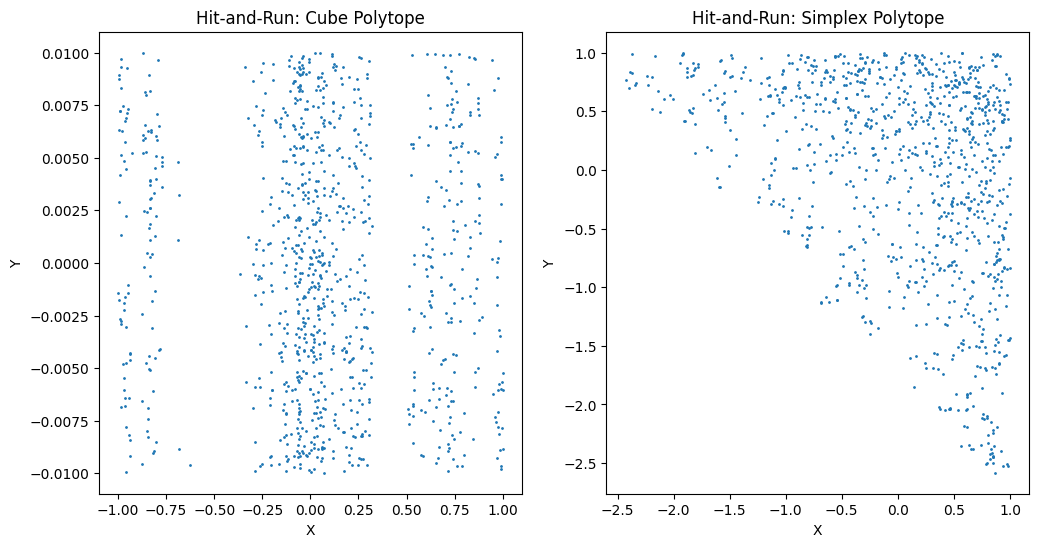

In [7]:
"""
Hit-and-run sampler.

Francesc Font-Clos
Oct 2018
"""
import numpy as np
from scipy.spatial.distance import norm

import tqdm


class HitAndRun(object):
    """Hit-and-run sampler."""

    def __init__(self, polytope=None, starting_point=None,
                 n_samples=100, thin=1):
        """
        Create a hit-and-run sampler.

        Parameters
        ----------
        polytope: hitandrun.polytope
            The convex polytope to be sampled.
        starting_point: np.array
            Initial condition. Must be inside the polytope.
        n_samples: int
            Number of desired samples.
        thin : int
            Thinning factor, increase to get independent samples.

        """
        # make sure we got a point inside the polytope
        assert starting_point is not None
        assert len(starting_point) == polytope.dim
        assert polytope.check_inside(starting_point)

        self.polytope = polytope
        self.starting_point = starting_point
        self.n_samples = n_samples
        self.thin = thin
        # place starting point as current point
        self.current = starting_point
        # set a starting random direction
        self._set_random_direction()
        # create empty list of samples
        self.samples = []

    def get_samples(self, n_samples=None, thin=None):
        """Get the requested samples."""
        self.samples = []
        if n_samples is not None:
            self.n_samples = n_samples
        if thin is not None:
            self.thin = thin

        # keep only one every thin
        for i in tqdm.tqdm(
            range(self.n_samples),
            desc="hit-and-run steps:"
        ):
            for _ in range(self.thin):
                self._step()
            self._add_current_to_samples()
        return np.array(self.samples)

    # private functions
    def _step(self):
        """Make one step."""
        # set random direction
        self._set_random_direction()
        # find lambdas
        self._find_lambdas()
        # find smallest positive and negative lambdas
        try:
            lam_plus = np.min(self.lambdas[self.lambdas > 0])
            lam_minus = np.max(self.lambdas[self.lambdas < 0])
        except(Exception):
            raise RuntimeError("The current direction does not intersect"
                               "any of the hyperplanes.")
        # throw random point between lambdas
        lam = np.random.uniform(low=lam_minus, high=lam_plus)
        # compute new point and add it
        new_point = self.current + lam * self.direction
        self.current = new_point

    def _find_lambdas(self):
        """
        Find the lambda value for each hyperplane.

        The lambda value is the distance we have to travel
        in the current direction, from the current point, to
        reach a given hyperplane.
        """
        A = self.polytope.A
        p = self.polytope.auxiliar_points

        lambdas = []
        for i in range(self.polytope.nplanes):
            if np.isclose(self.direction @ A[i], 0):
                lambdas.append(np.nan)
            else:
                lam = ((p[i] - self.current) @ A[i]) / (self.direction @ A[i])
                lambdas.append(lam)
        self.lambdas = np.array(lambdas)

    def _set_random_direction(self):
        """Set a unitary random direction in which to travel."""
        direction = np.random.randn(self.polytope.dim)
        self.direction = direction / norm(direction)

    def _add_current_to_samples(self):
        self.samples.append(list(self.current))

"""
A class to hold polytopes in H-representation.

Francesc Font-Clos
Oct 2018
"""
import numpy as np


class Polytope(object):
    """A polytope in H-representation."""

    def __init__(self, A=None, b=None):
        """
        Create a polytope in H-representation.

        The polytope is defined as the set of
        points x in Rn such that

        A x <= b

        """
        # dimensionality verifications
        assert A is not None and b is not None
        assert len(b.shape) == 1
        assert len(A.shape) == 2
        assert A.shape[0] == len(b)
        # store data
        self.A = A
        self.b = b
        self.dim = A.shape[1]
        self.nplanes = A.shape[0]
        self._find_auxiliar_points_in_planes()

    def check_inside(self, point):
        """Check if a point is inside the polytope."""
        checks = self.A@point <= self.b
        check = np.all(checks)
        return check

    def _find_auxiliar_points_in_planes(self):
        """Find an auxiliar point for each plane."""
        aux_points = [self._find_auxiliar_point(self.A[i],
                                                self.b[i])
                      for i in range(self.nplanes)]
        self.auxiliar_points = aux_points

    def _find_auxiliar_point(self, Ai, bi):
        """Find an auxiliar point for one plane."""
        p = np.zeros(self.dim)
        j = np.argmax(Ai != 0)
        p[j] = bi / Ai[j]
        return p


A_narrow = np.array([
    [1, 0, 0], [-1, 0, 0], 
    [0, 10, 0], [0, -10, 0], 
    [0, 0, 1], [0, 0, -1]
])
b_narrow = np.array([1, 1, 0.1, 0.1, 1, 1])  # Narrow extent in the y-dimension

narrow_polytope = Polytope(A=A_narrow, b=b_narrow)


A_simplex = np.array([
    [1, 0, 0], [0, 1, 0], 
    [0, 0, 1], [-1, -1, -1]
])
b_simplex = np.array([1, 1, 1, 1])  

simplex_polytope = Polytope(A=A_simplex, b=b_simplex)

def run_hit_and_run(polytope, starting_point, n_samples=1000):
    sampler = HitAndRun(polytope=polytope, starting_point=starting_point, n_samples=n_samples)
    return sampler.get_samples()
starting_point_cube = np.array([0, 0, 0])  # Inside the unit cube
starting_point_simplex = np.array([0.25, 0.25, 0.25])  # Inside the simplex
samples_cube = run_hit_and_run(narrow_polytope, starting_point_cube)
samples_simplex = run_hit_and_run(simplex_polytope, starting_point_simplex)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(samples_cube[:, 0], samples_cube[:, 1], s=1)
plt.title("Hit-and-Run: Cube Polytope")
plt.xlabel("X")
plt.ylabel("Y")
plt.subplot(1, 2, 2)
plt.scatter(samples_simplex[:, 0], samples_simplex[:, 1], s=1)
plt.title("Hit-and-Run: Simplex Polytope")
plt.xlabel("X")
plt.ylabel("Y")

plt.show()


hit-and-run steps:: 100%|██████████| 5000/5000 [00:00<00:00, 11996.57it/s]
/var/folders/2t/t_blrm1n6z7fln5ts2692m6r0000gn/T/ipykernel_46186/2849506880.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


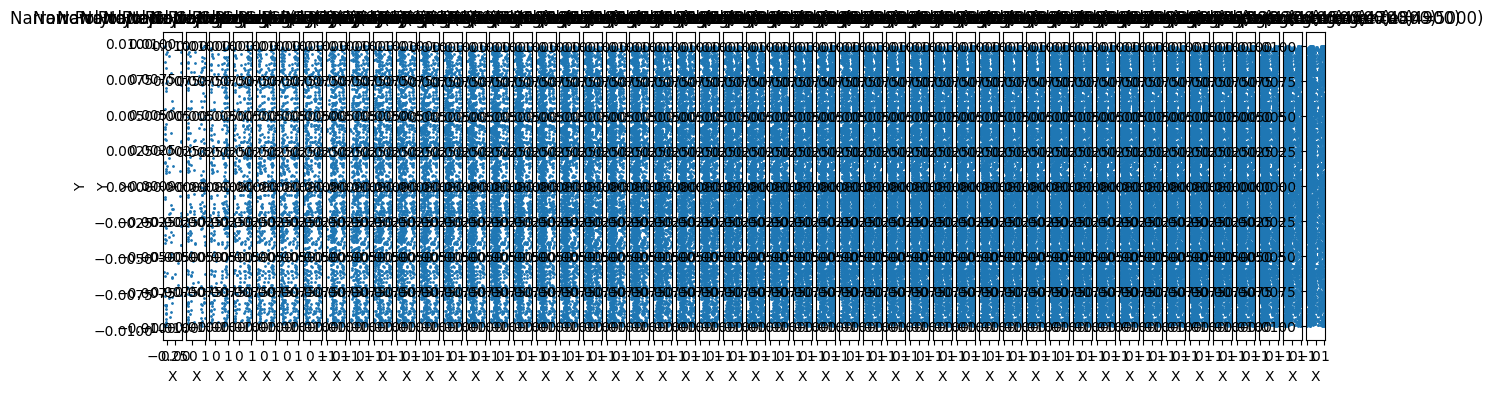

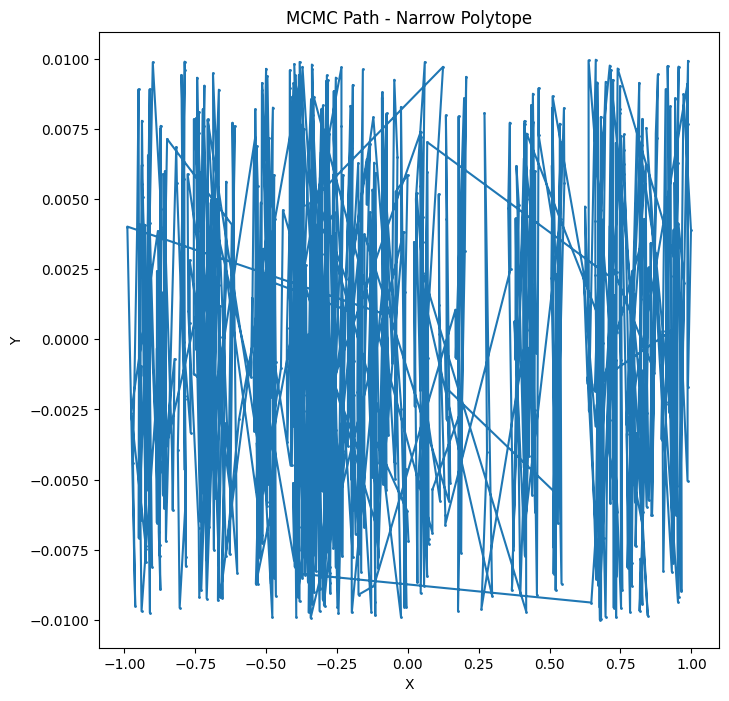

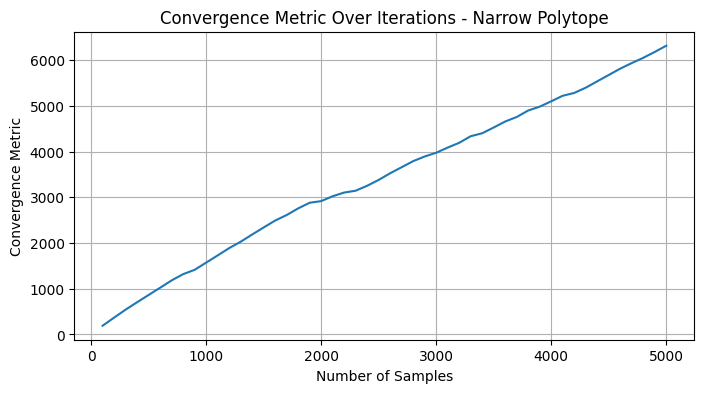

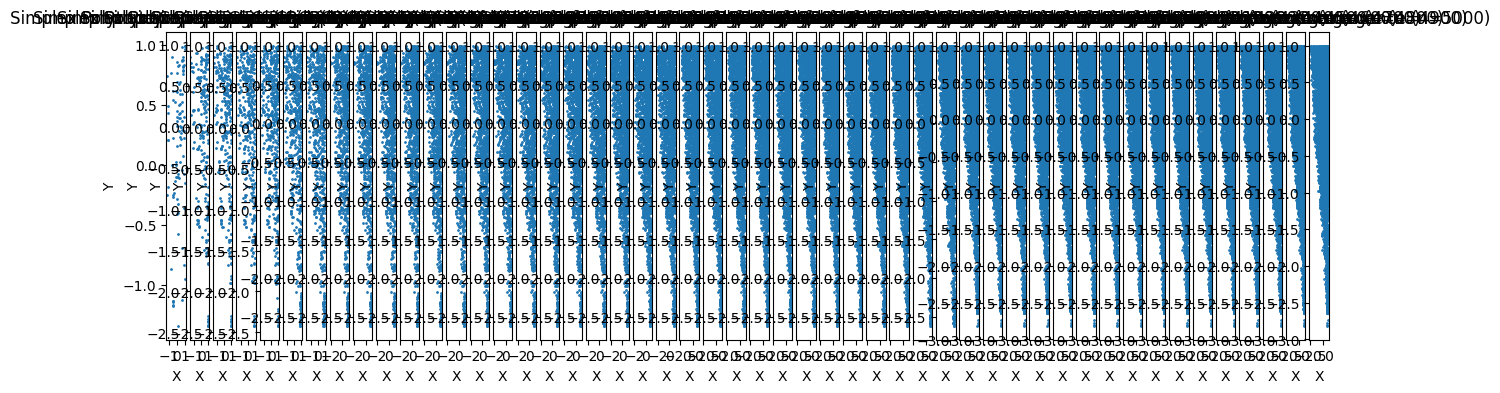

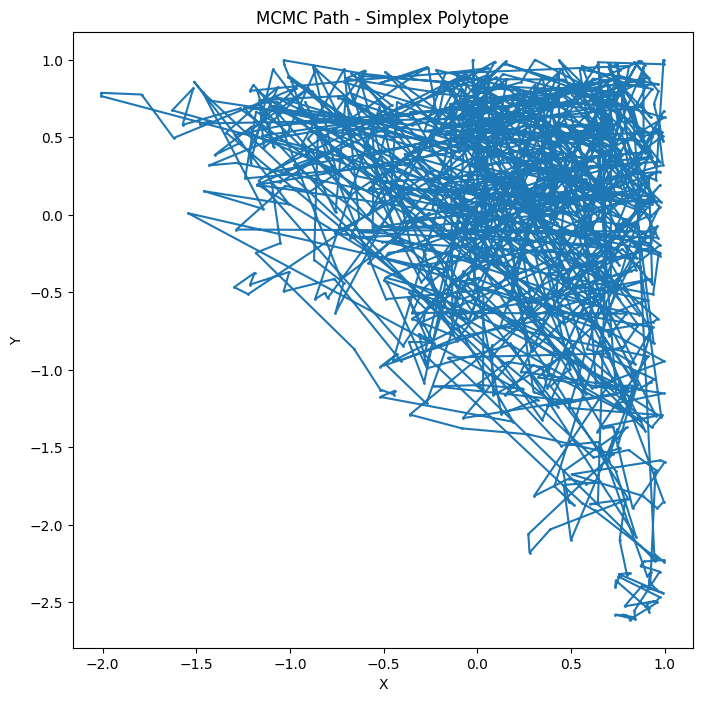

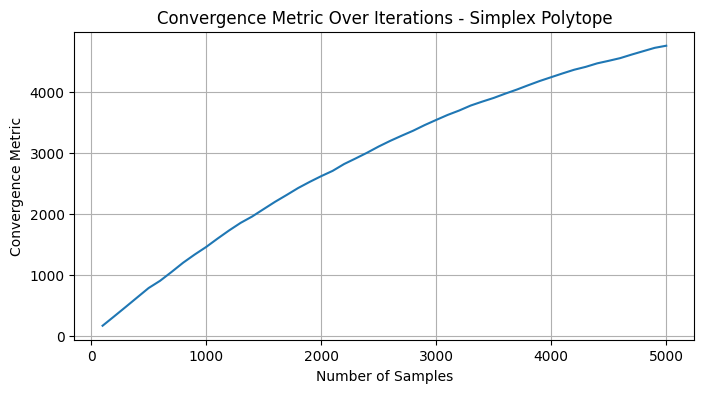

In [9]:
def calculate_convergence_metric(samples, bin_edges):
    """Calculate a simple convergence metric based on histogram comparison."""
    hist, _ = np.histogramdd(samples, bins=bin_edges)
    expected_count = len(samples) / np.prod([len(edges) - 1 for edges in bin_edges])
    return np.sum(np.abs(hist - expected_count))

def plot_convergence_metric(samples, polytope, intervals, bin_edges, title):
    """Plot the convergence metric over iterations."""
    metrics = [calculate_convergence_metric(samples[:interval], bin_edges) for interval in intervals]
    plt.figure(figsize=(8, 4))
    plt.plot(intervals, metrics)
    plt.xlabel('Number of Samples')
    plt.ylabel('Convergence Metric')
    plt.title(f'Convergence Metric Over Iterations - {title}')
    plt.grid(True)
    plt.show()

def plot_samples_over_time(samples, title, intervals):
    """
    Plot samples at different intervals to show convergence.
    
    Args:
    samples: Array of sampled points.
    title: Title for the plots.
    intervals: List of intervals at which to plot the samples.
    """
    plt.figure(figsize=(15, 4))
    for i, num_samples in enumerate(intervals):
        plt.subplot(1, len(intervals), i + 1)
        plt.scatter(samples[:num_samples, 0], samples[:num_samples, 1], s=1)
        plt.title(f"{title} (n={num_samples})")
        plt.xlabel('X')
        plt.ylabel('Y')
    plt.tight_layout()
    plt.show()

def plot_mcmc_path(samples, title, max_points=1000):
    """
    Plot the path of the MCMC process.
    
    Args:
    samples: Array of sampled points.
    title: Title for the plot.
    max_points: Maximum number of points to include in the path plot.
    """
    plt.figure(figsize=(8, 8))
    plt.plot(samples[:max_points, 0], samples[:max_points, 1], '-o', markersize=1)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

def calculate_convergence_metric(samples, bin_edges):
    """
    Calculate a simple convergence metric based on histogram comparison.
    
    Args:
    samples: Array of sampled points.
    bin_edges: List of bin edges for each dimension.
    
    Returns:
    A convergence metric based on the deviation of the sampled histogram from uniform.
    """
    hist, _ = np.histogramdd(samples, bins=bin_edges)
    expected_count = len(samples) / np.prod([len(edges) - 1 for edges in bin_edges])
    return np.sum(np.abs(hist - expected_count))

def plot_convergence_metric(samples, polytope, intervals, bin_edges, title):
    """
    Plot the convergence metric over iterations.
    
    Args:
    samples: Array of sampled points.
    polytope: The polytope object.
    intervals: List of intervals at which to calculate the metric.
    bin_edges: List of bin edges for each dimension.
    title: Title for the plot.
    """
    metrics = [calculate_convergence_metric(samples[:interval], bin_edges) for interval in intervals]
    plt.figure(figsize=(8, 4))
    plt.plot(intervals, metrics)
    plt.xlabel('Number of Samples')
    plt.ylabel('Convergence Metric')
    plt.title(f'Convergence Metric Over Iterations - {title}')
    plt.grid(True)
    plt.show()


def plot_samples_over_time(samples, title, intervals):
    """Plot samples at different intervals to show convergence."""
    plt.figure(figsize=(15, 4))
    for i, num_samples in enumerate(intervals):
        plt.subplot(1, len(intervals), i + 1)
        plt.scatter(samples[:num_samples, 0], samples[:num_samples, 1], s=1)
        plt.title(f"{title} (n={num_samples})")
        plt.xlabel('X')
        plt.ylabel('Y')
    plt.tight_layout()
    plt.show()

def plot_mcmc_path(samples, title, max_points=1000):
    """Plot the path of the MCMC process."""
    plt.figure(figsize=(8, 8))
    plt.plot(samples[:max_points, 0], samples[:max_points, 1], '-o', markersize=1)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

from scipy.spatial.distance import euclidean

def compute_average_distance(samples, centroid):
    """Compute the average distance of the samples to the centroid."""
    return np.mean([euclidean(sample, centroid) for sample in samples])

bin_edges_narrow = [np.linspace(-1, 1, 10), np.linspace(-0.1, 0.1, 5), np.linspace(-1, 1, 10)]
bin_edges_simplex = [np.linspace(-1, 1, 20), np.linspace(-1, 1, 20), np.linspace(-1, 1, 20)]

# Intervals at which to calculate the metric
intervals = np.linspace(100, 5000, 50).astype(int)

# Generate samples for the narrow and simplex polytopes
samples_narrow = run_hit_and_run(narrow_polytope, starting_point_cube, n_samples=5000)
samples_simplex = run_hit_and_run(simplex_polytope, starting_point_simplex, n_samples=5000)

# Plot samples over time, the MCMC path, and the convergence metric for each polytope
plot_samples_over_time(samples_narrow, "Narrow Polytope Convergence", intervals)
plot_mcmc_path(samples_narrow, "MCMC Path - Narrow Polytope")
plot_convergence_metric(samples_narrow, narrow_polytope, intervals, bin_edges_narrow, "Narrow Polytope")

plot_samples_over_time(samples_simplex, "Simplex Polytope Convergence", intervals)
plot_mcmc_path(samples_simplex, "MCMC Path - Simplex Polytope")
plot_convergence_metric(samples_simplex, simplex_polytope, intervals, bin_edges_simplex, "Simplex Polytope")
